In [3]:
import librosa
import pickle
import numpy as np

# Load their tuned model from file
with open("model/their_tuned_model.pkl", 'rb') as file:
    pickle_model = pickle.load(file)

# Load the standard scaler that was used to train their model
from joblib import load
scaler = load('model/std_scaler.bin')

instr_list = ["cel", "cla", "flu", "gac", "gel", "org", "pia", "sax", "tru", "vio", "voi"]

def score_prob_of_being(y, sr=44100, being=None, sim=False):
    rms = librosa.feature.rms(y=y)
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = f'{np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
    for e in mfcc:
        to_append += f' {np.mean(e)}'

    df = np.array([[float(x) for x in to_append.split(" ")]])
    
    X = scaler.transform(df)
    
    if being:
        mse = np.sqrt(np.mean(np.power(y - orig_y, 2))) if sim else 0
        return pickle_model.predict_proba(X)[0][instr_list.index(being)] - mse
    else:
        return pickle_model.predict_proba(X)[0]

In [41]:
songname = "dataset/IRMAS-TrainingData/cel/065__[cel][nod][cla]0059__2.wav"
orig_y, sr = librosa.load(songname, sr=44100)
orig_y = np.real(librosa.istft(np.real(librosa.stft(orig_y))))
print("Probability of being what it actually is:", score_prob_of_being(orig_y, sr, "cel"))
tricked_class = "vio"
print("Probability of being what we want it to be:", score_prob_of_being(orig_y, sr, tricked_class))

Probability of being what it actually is: 0.9726734394355481
Probability of being what we want it to be: 0.013679821460051091


In [42]:
import numpy as np
from deap import base, creator, tools, algorithms

# Define the problem: Maximizing the fitness of the spectrogram
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

# Define the functions for initialization, mutation, crossover, and evaluation
def init_individual():
    y, sr = librosa.load(songname, sr=44100)
    return np.real(librosa.stft(y))

def mutate(individual, indpb):
    # Mutate an individual by adding a small random value to each element
    individual += np.random.normal(0, indpb, individual.shape)
    return individual,

def crossover(parent1, parent2):
    # Perform crossover by taking the average of corresponding elements
    return (parent1 + parent2) / 2,

def evaluate(individual):
    # Score the individual based on the probability of the model to predict it as what we want it to be
    return score_prob_of_being(np.real(librosa.istft(individual)), 44100, tricked_class, True),

# Set up the DEAP framework
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutate, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Create an initial population
population_size = 25
population = toolbox.population(n=population_size)

# Run the evolution
generations = 50
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)
population, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=population_size*2,
                                                cxpb=0.7, mutpb=0.2, ngen=generations, stats=stats, halloffame=None, verbose=True)

F:\sonic-subterfuge\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
F:\sonic-subterfuge\venv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg      	max      
0  	25    	0.0136798	0.0136798
1  	46    	0.0544881	0.219553 
2  	40    	0.175042 	0.413634 
3  	44    	0.343324 	0.549093 
4  	47    	0.451762 	0.594329 
5  	48    	0.498499 	0.594329 
6  	45    	0.52576  	0.594329 
7  	45    	0.597725 	0.63458  
8  	45    	0.602242 	0.63458  
9  	45    	0.614523 	0.66725  
10 	42    	0.620981 	0.685327 
11 	47    	0.659414 	0.685327 
12 	43    	0.667104 	0.685327 
13 	42    	0.678669 	0.685327 
14 	46    	0.681561 	0.685327 
15 	47    	0.685327 	0.685327 
16 	46    	0.685327 	0.685327 
17 	46    	0.685327 	0.685327 
18 	42    	0.685327 	0.685327 
19 	45    	0.685327 	0.685327 
20 	44    	0.685327 	0.685327 
21 	43    	0.685327 	0.685327 
22 	46    	0.685327 	0.685327 
23 	43    	0.685327 	0.685327 
24 	48    	0.685327 	0.685327 
25 	43    	0.685327 	0.685327 
26 	45    	0.685327 	0.685327 
27 	48    	0.685327 	0.685327 
28 	49    	0.685327 	0.685327 
29 	46    	0.685327 	0.685327 
30 	44    	0.685327 	0.685327 
31 	43  

In [43]:
# Access the best individual after evolution
best_individual = tools.selBest(population, k=1)[0]
best_fitness = best_individual.fitness.values[0]

print("Best Individual:", best_individual)
print(score_prob_of_being(np.real(librosa.istft(best_individual)), 44100))
print("Best Fitness:", best_fitness)

Best Individual: [[-5.7988167e+00 -3.3733554e+00 -2.7921233e-01 ...  1.3089415e-01
   1.1520057e+00  1.1570028e+00]
 [ 6.8412175e+00  1.3347368e-01  1.4848775e-01 ... -3.3664450e-01
  -7.2451216e-01 -8.6099011e-01]
 [-6.5312600e+00  9.6099873e+00 -1.3831991e-01 ... -5.9500188e-01
  -2.2640382e-01  7.7561611e-01]
 ...
 [ 1.9120956e-02 -9.5015988e-03 -1.2238148e-04 ... -1.0800329e-04
  -1.9776782e-04  2.8051657e-04]
 [-1.9114763e-02  7.7671735e-05  1.2436768e-04 ...  1.7429219e-04
   6.9467817e-05 -1.1280798e-04]
 [ 1.9087216e-02  9.4147446e-03 -1.1855532e-04 ... -2.1455128e-04
  -9.0342102e-05  3.3542622e-07]]
[0.1504687  0.02424245 0.03985929 0.00610268 0.02154403 0.01518305
 0.01745325 0.02570732 0.00852947 0.68595118 0.00495859]
Best Fitness: 0.6853273032652539


In [44]:
from IPython.lib.display import Audio
from IPython.display import display

orig, sr = librosa.load(songname, sr=44100)
print(orig, sr)
modi = librosa.istft(best_individual)
display(Audio(data=orig, rate=sr))
display(Audio(data=modi, rate=sr))

[ 0.03599548  0.03208923  0.02983093 ... -0.00271606 -0.0022583
 -0.001297  ] 44100


In [45]:
import soundfile as sf
sf.write('out.wav', modi, sr)

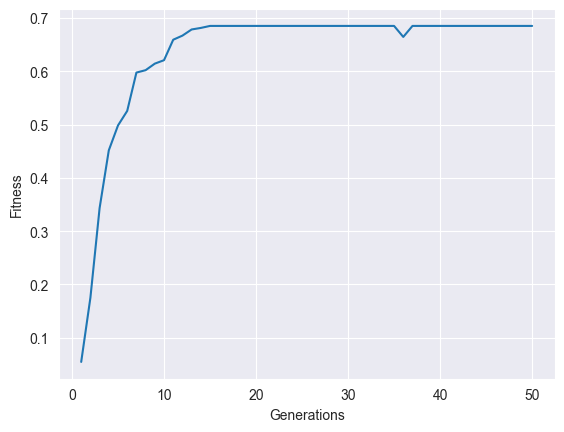

In [46]:
import matplotlib.pyplot as plt
plt.plot([x['gen'] for x in logbook[1:]], [x['avg'] for x in logbook[1:]])
plt.xlabel("Generations")
plt.ylabel("Fitness")
plt.show()